<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/langchain/custom/LangChain_Custom_LLMChat_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Langchain Custom Models

- https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html


- https://python.langchain.com/docs/how_to/custom_chat_model/

# Models
- https://huggingface.co/microsoft/Phi-3.5-vision-instruct
- https://github.com/microsoft/Phi-3CookBook

- https://huggingface.co/Qwen/Qwen2.5-1.5B-Instruct/tree/main
- https://github.com/QwenLM/Qwen2.5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Libraries

In [2]:
!pip install mlflow   optimum --quiet
! pip install  evaluate  textstat tiktoken -q
! pip install psutil pynvml -q
! pip install -q   bitsandbytes sentencepiece
! pip install datasets evaluate rouge_score -q
! pip install transformers==4.46.3 -q
! pip install accelerate -U -q
! pip install langchain  langchain-community -q
! pip install flash-attn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 89.9 MB/s eta 0:00:00


In [50]:
from typing import Any, Dict, List, Optional
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.outputs import ChatResult, ChatGeneration
from langchain_core.callbacks.manager import CallbackManagerForLLMRun
from langchain_core.callbacks.manager import AsyncCallbackManagerForLLMRun
from langchain_core.runnables import run_in_executor
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
from PIL import Image

class CustomLLMChat(BaseChatModel):
    model_name: str = "microsoft/Phi-3.5-vision-instruct"
    processor: AutoProcessor = None
    model: AutoModelForCausalLM = None
    model_path: str = None

    def __init__(self, model_path, **kwargs: Any) -> None:
        super().__init__(**kwargs)
        if model_path is not None:
            self.model_name = model_path

        self.processor = AutoProcessor.from_pretrained(self.model_name, trust_remote_code=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name, trust_remote_code=True, torch_dtype="auto", device_map="cuda:0"
        )

    def _call(
            self,
            prompt: str,
            image_path: Optional[str] = None,
            stop: Optional[List[str]] = None,
            run_manager: Optional[CallbackManagerForLLMRun] = None,
            **kwargs: Any,
    ) -> str:
        # Load and preprocess the image
        image = Image.open(image_path) if image_path else None
        inputs = self.processor(prompt, images=image, return_tensors="pt").to("cuda")

        # Generate response
        generate_ids = self.model.generate(
            **inputs, max_new_tokens=1000, eos_token_id=self.processor.tokenizer.eos_token_id
        )
        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
        response = self.processor.batch_decode(generate_ids,
                                               skip_special_tokens=True,
                                               clean_up_tokenization_spaces=False)[0]
        return response

    async def _acall(
            self,
            prompt: str,
            image_path: str,
            stop: Optional[List[str]] = None,
            run_manager: Optional[AsyncCallbackManagerForLLMRun] = None,
            **kwargs: Any,
    ) -> str:
        # Implement the async logic to generate a response from the model
        return await run_in_executor(
            None,
            self._call,
            prompt,
            image_path,
            stop,
            run_manager.get_sync() if run_manager else None,
            **kwargs,
        )

    @property
    def _llm_type(self) -> str:
        return "custom-llm-vision-chat"

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        return {"model_name": self.model_name}

    def _generate(
            self,
            messages: List[BaseMessage],
            stop: Optional[List[str]] = None,
            run_manager: Optional[CallbackManagerForLLMRun] = None,
            **kwargs: Any,
    ) -> ChatResult:
        # Assumes the first message contains the prompt and the image path is in metadata
        prompt = messages[0].content
        try:
            image_path = messages[0].metadata.get("image_path")
        except AttributeError:
            image_path = None
        response_text = self._call(prompt, image_path, stop, run_manager, **kwargs)

        # Create AIMessage with the response
        ai_message = AIMessage(content=response_text)
        return ChatResult(generations=[ChatGeneration(message=ai_message)])


def create_prompt(message: str, image_path: Optional[str] = None) -> List[BaseMessage]:
    user_prompt = '<|user|>\n'
    assistant_prompt = '<|assistant|>\n'
    prompt_suffix = "<|end|>\n"
    img_token = "<|image_1|>\n" if image_path else ""
    prompt = f"{user_prompt}{img_token}{message}{prompt_suffix}{assistant_prompt}"

    return [HumanMessage(content=prompt, metadata={"image_path": image_path})]




In [51]:
model_path ="/content/drive/MyDrive/MODELS/Phi-3.5-vision-instruct"

In [52]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

110

In [53]:
prompt = create_prompt("Describe this image", '/content/drive/MyDrive/Google AI Studio/forest.jpg')

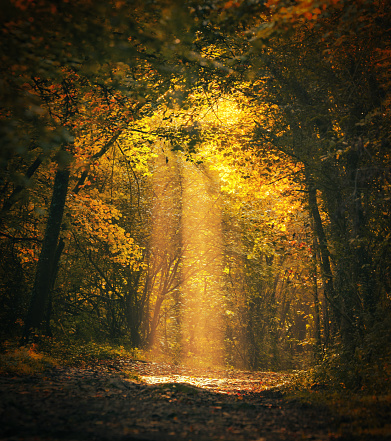

In [54]:
image_path = '/content/drive/MyDrive/Google AI Studio/forest.jpg'
image = Image.open(image_path)
image

In [55]:
prompt[0].content

'<|user|>\n<|image_1|>\nDescribe this image<|end|>\n<|assistant|>\n'

In [56]:
model_path = "/content/drive/MyDrive/MODELS/Phi-3.5-vision-instruct"

In [57]:
model = CustomLLMChat(model_path=model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [58]:
prompt[0].metadata["image_path"]

'/content/drive/MyDrive/Google AI Studio/forest.jpg'

In [59]:
import pprint

In [60]:
result = model.invoke(prompt)
print(result)

content='The image captures a serene scene of a forest path bathed in the soft glow of sunlight. The path, lined with trees on either side, is covered in a carpet of fallen leaves, their colors a mix of yellow, orange, and brown, indicative of the autumn season. The sunlight filters through the trees, creating a dappled effect on the path and illuminating the scene with a warm, golden hue. The perspective of the image is from the path itself, looking down its length, giving a sense of depth and inviting the viewer to imagine walking down this tranquil path. The image does not contain any discernible text or countable objects, and there are no visible actions taking place. The relative positions of the objects suggest a peaceful, undisturbed forest scene. The image is devoid of any aesthetic descriptions, focusing solely on the depicted scene.' additional_kwargs={} response_metadata={} id='run-9bce8b34-5be3-4646-bd9f-c68795f4f00c-0'


In [61]:
pprint.pprint(result.content)

('The image captures a serene scene of a forest path bathed in the soft glow '
 'of sunlight. The path, lined with trees on either side, is covered in a '
 'carpet of fallen leaves, their colors a mix of yellow, orange, and brown, '
 'indicative of the autumn season. The sunlight filters through the trees, '
 'creating a dappled effect on the path and illuminating the scene with a '
 'warm, golden hue. The perspective of the image is from the path itself, '
 'looking down its length, giving a sense of depth and inviting the viewer to '
 'imagine walking down this tranquil path. The image does not contain any '
 'discernible text or countable objects, and there are no visible actions '
 'taking place. The relative positions of the objects suggest a peaceful, '
 'undisturbed forest scene. The image is devoid of any aesthetic descriptions, '
 'focusing solely on the depicted scene.')


In [62]:
result2 =await model.ainvoke(prompt)

In [63]:
pprint.pprint(result2.content)

('The image captures a serene scene of a forest path bathed in the soft glow '
 'of sunlight. The path, lined with trees on either side, is covered in a '
 'carpet of fallen leaves, their colors a mix of yellow, orange, and brown, '
 'indicative of the autumn season. The sunlight filters through the trees, '
 'creating a dappled effect on the path and illuminating the scene with a '
 'warm, golden hue. The perspective of the image is from the path itself, '
 'looking down its length, giving a sense of depth and inviting the viewer to '
 'imagine walking down this tranquil path. The image does not contain any '
 'discernible text or countable objects, and there are no visible actions '
 'taking place. The relative positions of the objects suggest a peaceful, '
 'undisturbed forest scene. The image is devoid of any aesthetic descriptions, '
 'focusing solely on the depicted scene.')


In [64]:
del model
torch.cuda.empty_cache()
gc.collect()

21

In [38]:
import torch
from transformers import  AutoTokenizer
from typing import Any, Dict, List, Optional

In [65]:
class CustomLLMChat2(BaseChatModel):

    model_name: str = "Qwen/Qwen2.5-1.5B-Instruct"
    tokenizer : AutoTokenizer = None
    model: AutoModelForCausalLM = None
    model_path: str = None

    def __init__(self, model_path, **kwargs: Any) -> None:
        super().__init__(**kwargs)
        if model_path is not None:
            self.model_name = model_path

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name, trust_remote_code=True, torch_dtype="auto", device_map="cuda:0"
        )


    def _call(
            self,
            prompt: str,
            stop: Optional[List[str]] = None,
            run_manager: Optional[CallbackManagerForLLMRun] = None,
            **kwargs: Any,
    ) -> str:
        # Load and preprocess the image
        messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]

        text = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs  = self.tokenizer([text], return_tensors="pt").to(self.model.device)
        generated_ids = self.model.generate(
              **model_inputs,
              max_new_tokens=512
          )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
          ]

        response = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        return response

    async def _acall(
            self,
            prompt: str,
            stop: Optional[List[str]] = None,
            run_manager: Optional[AsyncCallbackManagerForLLMRun] = None,
            **kwargs: Any,
    ) -> str:
        # Implement the async logic to generate a response from the model
        return await run_in_executor(
            None,
            self._call,
            prompt,
            stop,
            run_manager.get_sync() if run_manager else None,
            **kwargs,
        )

    @property
    def _llm_type(self) -> str:
        return "custom-llm-chat"

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        return {"model_name": self.model_name}

    def _generate(
            self,
            messages: List[BaseMessage],
            stop: Optional[List[str]] = None,
            run_manager: Optional[CallbackManagerForLLMRun] = None,
            **kwargs: Any,
    ) -> ChatResult:
        # Assumes the first message contains the prompt and the image path is in metadata
        prompt = messages[0].content
        response_text = self._call(prompt,  stop, run_manager, **kwargs)

        # Create AIMessage with the response
        ai_message = AIMessage(content=response_text)
        return ChatResult(generations=[ChatGeneration(message=ai_message)])


def create_prompt_chat(message: str ) -> List[BaseMessage]:

    assistant_prompt = '<|assistant|>\n'

    prompt = f"{message}{assistant_prompt}"

    return [HumanMessage(content=prompt)]

In [66]:
prompt2 = create_prompt_chat("How to explain Internet for a medieval knight?")

In [67]:
model_path_2 = "/content/drive/MyDrive/MODELS/Qwen2.5-1.5B-Instruct"

In [68]:
model2= CustomLLMChat2(model_path=model_path_2)

In [69]:
model2._llm_type

'custom-llm-chat'

In [70]:
model2._identifying_params

{'model_name': '/content/drive/MyDrive/MODELS/Qwen2.5-1.5B-Instruct'}

In [71]:
model2.model_name

'/content/drive/MyDrive/MODELS/Qwen2.5-1.5B-Instruct'

In [72]:
result = model2.invoke(prompt2)


In [73]:
pprint.pprint(result.content)

('To explain the internet to a medieval knight would be quite an unusual and '
 'challenging task due to significant differences in technology, knowledge, '
 'and understanding between their time period and ours. However, I can provide '
 'some simplified explanations of key concepts that might help bridge this '
 'gap:\n'
 '\n'
 '1. **Communication**: Explain how letters could travel long distances '
 'through messengers or postal systems like those used today.\n'
 '\n'
 '2. **Printing Press**: Describe how books were printed with movable type, '
 'which was relatively new at the time but still more advanced than '
 'handwritten manuscripts.\n'
 '\n'
 '3. **Navigation**: Explain how maps were made using stars, compasses, and '
 'other natural phenomena, much like modern sailors do.\n'
 '\n'
 '4. **Trade Goods**: Talk about bartering goods rather than digital '
 'currencies, emphasizing the value of rare items and commodities.\n'
 '\n'
 '5. **Knowledge Transmission**: Discuss how infor